### Natural Language Processing Assignment

#### Course: TIPP Intake 2

#### Student Name:  Lim Tse Yong Sharon

Note: by typing your full name, it is taken that you have read and understood the declaration below.

#### Declaration:

- I declare that this assignment is my original work. I understand that if I am suspected of plagiarism, my enrolment in the programme may be terminated.

- I declare that I have a back-up electronic copy of this report for immediate submission.

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import os
import re, nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.collocations import *
import string
import pandas as pd
from pandas import DataFrame
import numpy as np
from tqdm import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Step 1: Decide on the dataset of choice and load the dataset

In [3]:
# load dataset
text = ''
with open('Data/News/News Set B.txt','r', encoding='utf-8') as f:
# with open('Data/News/News Set B.txt','r') as f:
    text = " ".join([l.strip() for l in f.readlines()])

In [4]:
text[0:500]

'URL: http://www.nytimes.com/2016/06/30/sports/baseball/washington-nationals-max-scherzer-baffles-mets-completing-a-sweep.html  WASHINGTON — Stellar pitching kept the Mets afloat in the first half of last season despite their offensive woes. But they cannot produce an encore of their pennant-winning season if their lineup keeps floundering while their pitching is nicked, bruised and stretched thin. “We were going to ride our pitching,” Manager Terry Collins said before Wednesday’s game. “But we’r'

In [5]:
# remove URLs
p = re.compile('URL:\shttp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|\
                [!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-5-20e2ddc4b282>:3: DeprecationWarning: invalid escape sequence \s
  [!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')


In [6]:
articles = p.split(text)

In [7]:
for i, line in enumerate(articles): articles[i] = line.strip()

In [8]:
print(articles[1])

WASHINGTON — Stellar pitching kept the Mets afloat in the first half of last season despite their offensive woes. But they cannot produce an encore of their pennant-winning season if their lineup keeps floundering while their pitching is nicked, bruised and stretched thin. “We were going to ride our pitching,” Manager Terry Collins said before Wednesday’s game. “But we’re not riding it right now. We’ve got as many problems with our pitching as we do anything.” Wednesday’s 4-2 loss to the Washington Nationals was cruel for the already-limping Mets. Pitching in Steven Matz’s place, the spot starter Logan Verrett allowed two runs over five innings. But even that was too large a deficit for the Mets’ lineup to overcome against Max Scherzer, the Nationals’ starter. “We’re not even giving ourselves chances,” Collins said, adding later, “We just can’t give our pitchers any room to work.” The Mets did not score until the ninth inning, when a last-gasp two-run homer by James Loney off Nationals

In [9]:
# load data into a dataframe
df = DataFrame(articles,columns=['content'])
df.head()

,content
0,
1,WASHINGTON — Stellar pitching kept the Mets af...
2,Mayor Bill de Blasio’s counsel and chief legal...
3,In the early morning hours of Labor Day last y...
4,It was the Apple Store in New York City before...


In [10]:
# total number of news articles before cleaning
len(df)

8889

#### Step 2: Clean and prepare the data

In [11]:
# remove empty rows
nan_value = float("NaN")

# Convert NaN values to empty string
df.replace("", nan_value, inplace=True)
df.dropna(subset = ["content"], inplace=True)
df.head()

,content
1,WASHINGTON — Stellar pitching kept the Mets af...
2,Mayor Bill de Blasio’s counsel and chief legal...
3,In the early morning hours of Labor Day last y...
4,It was the Apple Store in New York City before...
5,OMAHA — The United States Olympic swimming tri...


In [12]:
# total number of news articles after removing empty rows
len(df)

8884

In [13]:
# remove words containing numbers and replace with a single space
# convert to lowercase
lower_alpha = lambda x: re.sub(r"""\w*\d\w*""", ' ', x.lower())
df['content'] = df.content.map(lower_alpha)
df.head()

,content
1,washington — stellar pitching kept the mets af...
2,mayor bill de blasio’s counsel and chief legal...
3,in the early morning hours of labor day last y...
4,it was the apple store in new york city before...
5,omaha — the united states olympic swimming tri...


In [14]:
# remove all punctuations
punc_re = lambda x: re.sub(r"""[\.,—“”’:;#$?%!&()_'`*""˜{|}~]""", ' ', x)

df['content'] = df.content.map(punc_re)
df.head()

,content
1,washington stellar pitching kept the mets af...
2,mayor bill de blasio s counsel and chief legal...
3,in the early morning hours of labor day last y...
4,it was the apple store in new york city before...
5,omaha the united states olympic swimming tri...


#### Step 3: Perform an initial exploratory data analysis on the dataset 
A word cloud is useful to obtain a visual representation of most common words.

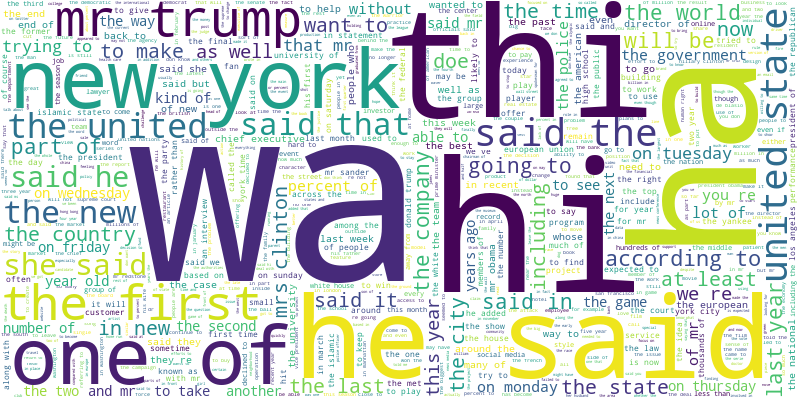

In [17]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together
long_string = ','.join(list(df['content'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=10000, width=800, height=400, contour_width=20, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### Step 4: Feature Engineering

In [18]:
# tokenize the reviews into words
# insert the list of tokens into a new column (series) call tokens
df['tokens'] = df.content.map(word_tokenize)
df.head()

,content,tokens
1,washington stellar pitching kept the mets af...,"[washington, stellar, pitching, kept, the, met..."
2,mayor bill de blasio s counsel and chief legal...,"[mayor, bill, de, blasio, s, counsel, and, chi..."
3,in the early morning hours of labor day last y...,"[in, the, early, morning, hours, of, labor, da..."
4,it was the apple store in new york city before...,"[it, was, the, apple, store, in, new, york, ci..."
5,omaha the united states olympic swimming tri...,"[omaha, the, united, states, olympic, swimming..."


In [20]:
# remove stop words
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
  
stop_lambda = lambda x: [y for y in x if y not in stop_words]
df['tokens_stop'] = df.tokens.apply(stop_lambda)
df.head()

,content,tokens,tokens_stop
1,washington stellar pitching kept the mets af...,"[washington, stellar, pitching, kept, the, met...","[washington, stellar, pitching, kept, mets, af..."
2,mayor bill de blasio s counsel and chief legal...,"[mayor, bill, de, blasio, s, counsel, and, chi...","[mayor, bill, de, blasio, counsel, chief, lega..."
3,in the early morning hours of labor day last y...,"[in, the, early, morning, hours, of, labor, da...","[early, morning, hours, labor, day, last, year..."
4,it was the apple store in new york city before...,"[it, was, the, apple, store, in, new, york, ci...","[apple, store, new, york, city, thing, apple, ..."
5,omaha the united states olympic swimming tri...,"[omaha, the, united, states, olympic, swimming...","[omaha, united, states, olympic, swimming, tri..."


In [21]:
# perform  basic lemmatization
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

lemmatizer_lambda = lambda x: [lemmatizer.lemmatize(y) for y in x]
df['tokens_lemma_simple'] = df.tokens_stop.apply(lemmatizer_lambda)
df.head()

,content,tokens,tokens_stop,tokens_lemma_simple
1,washington stellar pitching kept the mets af...,"[washington, stellar, pitching, kept, the, met...","[washington, stellar, pitching, kept, mets, af...","[washington, stellar, pitching, kept, mets, af..."
2,mayor bill de blasio s counsel and chief legal...,"[mayor, bill, de, blasio, s, counsel, and, chi...","[mayor, bill, de, blasio, counsel, chief, lega...","[mayor, bill, de, blasio, counsel, chief, lega..."
3,in the early morning hours of labor day last y...,"[in, the, early, morning, hours, of, labor, da...","[early, morning, hours, labor, day, last, year...","[early, morning, hour, labor, day, last, year,..."
4,it was the apple store in new york city before...,"[it, was, the, apple, store, in, new, york, ci...","[apple, store, new, york, city, thing, apple, ...","[apple, store, new, york, city, thing, apple, ..."
5,omaha the united states olympic swimming tri...,"[omaha, the, united, states, olympic, swimming...","[omaha, united, states, olympic, swimming, tri...","[omaha, united, state, olympic, swimming, tria..."


In [22]:
# Perform lemmitization considering parts of speech tagging

from nltk.tag import pos_tag

pos_lambda = lambda x: nltk.pos_tag(x)
df['tokens_pos'] = (df.tokens_stop.apply(pos_lambda))
df.head()

,content,tokens,tokens_stop,tokens_lemma_simple,tokens_pos
1,washington stellar pitching kept the mets af...,"[washington, stellar, pitching, kept, the, met...","[washington, stellar, pitching, kept, mets, af...","[washington, stellar, pitching, kept, mets, af...","[(washington, NN), (stellar, NN), (pitching, N..."
2,mayor bill de blasio s counsel and chief legal...,"[mayor, bill, de, blasio, s, counsel, and, chi...","[mayor, bill, de, blasio, counsel, chief, lega...","[mayor, bill, de, blasio, counsel, chief, lega...","[(mayor, NN), (bill, NN), (de, IN), (blasio, F..."
3,in the early morning hours of labor day last y...,"[in, the, early, morning, hours, of, labor, da...","[early, morning, hours, labor, day, last, year...","[early, morning, hour, labor, day, last, year,...","[(early, RB), (morning, NN), (hours, NNS), (la..."
4,it was the apple store in new york city before...,"[it, was, the, apple, store, in, new, york, ci...","[apple, store, new, york, city, thing, apple, ...","[apple, store, new, york, city, thing, apple, ...","[(apple, NN), (store, NN), (new, JJ), (york, N..."
5,omaha the united states olympic swimming tri...,"[omaha, the, united, states, olympic, swimming...","[omaha, united, states, olympic, swimming, tri...","[omaha, united, state, olympic, swimming, tria...","[(omaha, RB), (united, JJ), (states, NNS), (ol..."


In [23]:
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

# convert the naming scheme to one that is recognized by WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return "a"
    elif treebank_tag.startswith('V'):
        return "v"
    elif treebank_tag.startswith('N'):
        return "n"
    elif treebank_tag.startswith('R'):
        return "r"
    else:
        return "n"

In [24]:
lemmatizer = WordNetLemmatizer()
lemmatizer_fun = lambda x: lemmatizer.lemmatize(*x)
df['tokens_lemma_with_pos'] = df.tokens_pos\
                        .apply(lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x])\
                        .apply(lambda x: [lemmatizer_fun(y) for y in x])
df.head()

,content,tokens,tokens_stop,tokens_lemma_simple,tokens_pos,tokens_lemma_with_pos
1,washington stellar pitching kept the mets af...,"[washington, stellar, pitching, kept, the, met...","[washington, stellar, pitching, kept, mets, af...","[washington, stellar, pitching, kept, mets, af...","[(washington, NN), (stellar, NN), (pitching, N...","[washington, stellar, pitching, keep, mets, af..."
2,mayor bill de blasio s counsel and chief legal...,"[mayor, bill, de, blasio, s, counsel, and, chi...","[mayor, bill, de, blasio, counsel, chief, lega...","[mayor, bill, de, blasio, counsel, chief, lega...","[(mayor, NN), (bill, NN), (de, IN), (blasio, F...","[mayor, bill, de, blasio, counsel, chief, lega..."
3,in the early morning hours of labor day last y...,"[in, the, early, morning, hours, of, labor, da...","[early, morning, hours, labor, day, last, year...","[early, morning, hour, labor, day, last, year,...","[(early, RB), (morning, NN), (hours, NNS), (la...","[early, morning, hour, labor, day, last, year,..."
4,it was the apple store in new york city before...,"[it, was, the, apple, store, in, new, york, ci...","[apple, store, new, york, city, thing, apple, ...","[apple, store, new, york, city, thing, apple, ...","[(apple, NN), (store, NN), (new, JJ), (york, N...","[apple, store, new, york, city, thing, apple, ..."
5,omaha the united states olympic swimming tri...,"[omaha, the, united, states, olympic, swimming...","[omaha, united, states, olympic, swimming, tri...","[omaha, united, state, olympic, swimming, tria...","[(omaha, RB), (united, JJ), (states, NNS), (ol...","[omaha, united, state, olympic, swim, trial, s..."


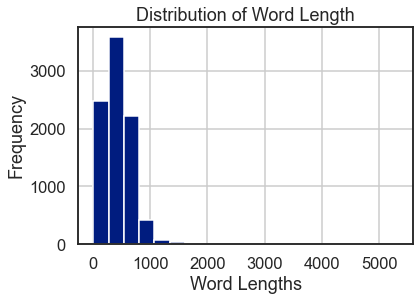

In [25]:
sns.set_style('white')
sns.set_palette('dark')
sns.set_context('talk')

# create a histogram for the distribution of word lengths
word_lengths = pd.Series([len(x) for x in df['tokens_lemma_with_pos']])

ax = word_lengths.hist(bins=20)
ax.ticklabel_format(style='plain')
ax.set(xlabel='Word Lengths', ylabel='Frequency', 
       title='Distribution of Word Length');

In [27]:
df = df.astype(str)

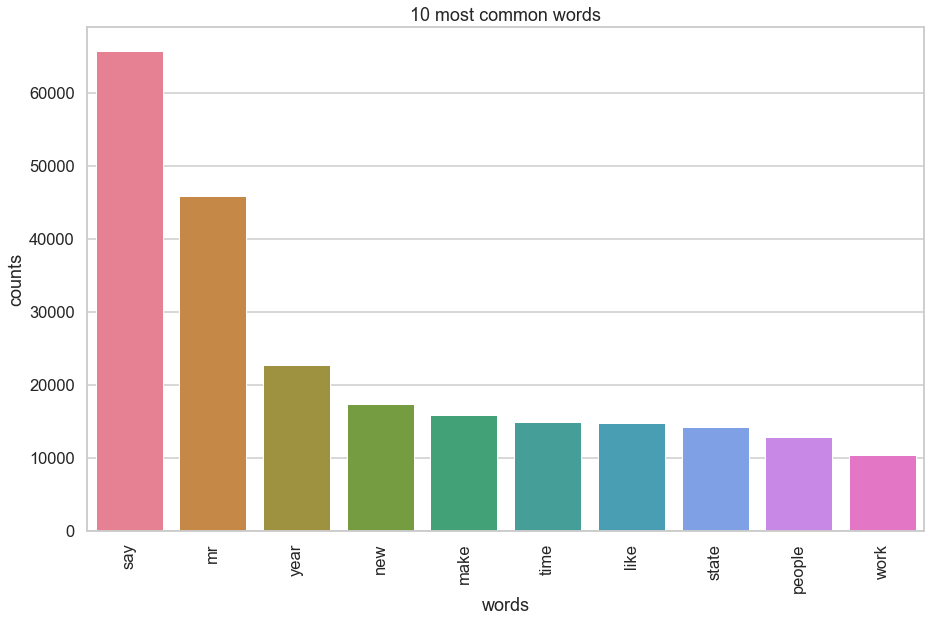

In [28]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
    
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['tokens_lemma_with_pos'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

#### Step 5: Prepare the topic model object

In [75]:
# function to display topics and sort the terms
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### Topic Modelling using LDA

#### Step 6: Prepare the document term matrix

- Load in the documents from its source
- The LDA topic model algorithm requires a document word matrix as the main input.
- Vectorise the document using count vectorizing
- LDA can only use raw term counts for LDA because it is a probabilistic graphical model

In [31]:
no_features = 1000

# Initialise the count vectorizer with the English stop words
tf_vectorizer = CountVectorizer(max_features=no_features, stop_words='english')

# Fit and transform the processed content
tf_vectorized_documents = tf_vectorizer.fit_transform(df['tokens_lemma_with_pos'])
tf_feature_names = tf_vectorizer.get_feature_names()

#### Step 7: Parameter selection to select on the "optimal" number of topics

- Use metrics such as perplexity and log-likelihood to determine good  model performance
- A model with higher log-likelihood and lower perplexity is considered to be good
- Begin by pre-specifying an initial range of "sensible" values
- Apply LDA for all possible topic size k and determine its log-likelihood and perplexity measures
- Select the LDA with the highest log-likelihood and lowest perplexity measures

In [34]:
# set boundaries for minimum and maximum number of topics
kmin=15
kmax=25

Looping through the possible range of topic numbers by implementing a for loop to create new LDA objects, fit it with the document term metric, and call the relevant methods in the lda object to return to log_likehood and perplexity. The results are then inserted into the list topic_models.

In [35]:
topic_models = []

for k in tqdm(range(kmin,kmax+1)):
    print("Applying and scoring LDA for k=%d ..." % k )
    
    lda_model = LatentDirichletAllocation(n_components= k, max_iter=5, 
                                          learning_method='online', learning_offset=50.,
                                          random_state=8)
    
    lda_output = lda_model.fit_transform(tf_vectorized_documents)  
    log_likelihood = lda_model.score(tf_vectorized_documents)
    perplexity = lda_model.perplexity(tf_vectorized_documents)
    topic_models.append( (k,lda_model,lda_output, log_likelihood, perplexity) ) 

  0%|          | 0/11 [00:00<?, ?it/s]

Applying and scoring LDA for k=15 ...


  9%|▉         | 1/11 [02:49<28:14, 169.40s/it]

Applying and scoring LDA for k=16 ...


 18%|█▊        | 2/11 [05:23<24:42, 164.69s/it]

Applying and scoring LDA for k=17 ...


 27%|██▋       | 3/11 [07:46<21:05, 158.23s/it]

Applying and scoring LDA for k=18 ...


 36%|███▋      | 4/11 [10:28<18:35, 159.32s/it]

Applying and scoring LDA for k=19 ...


 45%|████▌     | 5/11 [13:09<15:58, 159.83s/it]

Applying and scoring LDA for k=20 ...


 55%|█████▍    | 6/11 [15:53<13:25, 161.11s/it]

Applying and scoring LDA for k=21 ...


 64%|██████▎   | 7/11 [18:37<10:48, 162.09s/it]

Applying and scoring LDA for k=22 ...


 73%|███████▎  | 8/11 [21:34<08:19, 166.42s/it]

Applying and scoring LDA for k=23 ...


 82%|████████▏ | 9/11 [24:31<05:39, 169.57s/it]

Applying and scoring LDA for k=24 ...


 91%|█████████ | 10/11 [28:00<03:01, 181.48s/it]

Applying and scoring LDA for k=25 ...


100%|██████████| 11/11 [31:03<00:00, 169.42s/it]


In [36]:
# Prints the number of topics and corresponding perplexity and log likelihood.
for model in topic_models:
  print("k topics : % 2d, Log Likelihood : % 5.2f   Perplexity : %5.2f" %(model[0], model[3], model[4]))  

k topics :  15, Log Likelihood : -12280422.42   Perplexity : 480.51
k topics :  16, Log Likelihood : -12256352.17   Perplexity : 474.73
k topics :  17, Log Likelihood : -12267555.73   Perplexity : 477.41
k topics :  18, Log Likelihood : -12267501.66   Perplexity : 477.40
k topics :  19, Log Likelihood : -12237674.24   Perplexity : 470.29
k topics :  20, Log Likelihood : -12244247.16   Perplexity : 471.85
k topics :  21, Log Likelihood : -12242178.19   Perplexity : 471.36
k topics :  22, Log Likelihood : -12236401.82   Perplexity : 469.99
k topics :  23, Log Likelihood : -12224897.24   Perplexity : 467.28
k topics :  24, Log Likelihood : -12255661.82   Perplexity : 474.56
k topics :  25, Log Likelihood : -12224365.12   Perplexity : 467.15


#### Step 8: Evaluate the topic and terms.

In [37]:
best_k = 25
best_lda_model = topic_models[best_k - kmin][1]
no_top_words = 15
display_topics(best_lda_model, tf_feature_names, no_top_words)

Topic 0:
say state federal law mr department case report investigation year agency use new make time
Topic 1:
percent year price market rise rate say oil stock quarter million increase high sale report
Topic 2:
european union britain europe say british london leave country france germany french vote minister german
Topic 3:
say police officer mr case charge year arrest prosecutor prison crime sentence man court criminal
Topic 4:
party vote election political state say justice law mr right voter president court republican senate
Topic 5:
like say food make restaurant hotel store new room cook open day fashion use year
Topic 6:
like make say new time work year think play film way thing know music people
Topic 7:
player say play year win match time round coach tournament open final title second champion
Topic 8:
mr say year time black white american write new add interview make african lead york
Topic 9:
city say state new people year mayor water official resident public community local h

#### Step 9: Use pyLDAvis to visualize topic models
- To interpret the topics in a topic model that has been fit to a corpus of text data
- A good topic model will have non-overlapping wirh fairly big sized area for each topic
- Pass into the plLDAVIS the three parameters of (1) the LDA object, (2) the document term matrix and (3) the Count Vectorizer

In [38]:
# Plot the pyLDAvis visualizer with the above input
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf_vectorized_documents, tf_vectorizer)
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.018466 -0.123533       1        1  10.548320
24     0.014837 -0.118670       2        1   9.871083
19     0.004815 -0.180712       3        1   6.556607
14     0.092233  0.018514       4        1   5.823772
16     0.096931  0.057760       5        1   5.446601
0      0.000794  0.124240       6        1   5.166914
5     -0.105265 -0.130167       7        1   4.425416
22    -0.157432  0.064030       8        1   4.346909
13    -0.026315  0.006101       9        1   4.242449
11    -0.114498 -0.041329      10        1   3.924940
3      0.144243  0.047369      11        1   3.688480
12     0.021585  0.013634      12        1   3.633749
8      0.063683 -0.044246      13        1   3.563206
7      0.020535 -0.178135      14        1   3.351426
4      0.107883  0.102411      15        1   3.224131
9      0.020017  0.034528      16        1   3.088151
1     -0.178852  0.035155      17        1   3.031218
20    -0.205305  0.128189      18        1   2.999341
2      0.031028  0.013538      19        1   2.598545
23    -0.085069  0.023174      20        1   2.318599
10    -0.100798 -0.035385      21        1   2.152412
15     0.146035  0.011969      22        1   1.999032
21     0.042483 -0.131200      23        1   1.606235
18    -0.018751  0.246768      24        1   1.384577
17     0.203651  0.055995      25        1   1.007886, topic_info=        Term          Freq         Total Category  logprob  loglift
577       mr  46225.000000  46225.000000  Default  30.0000  30.0000
177  company   9799.000000   9799.000000  Default  29.0000  29.0000
929    trump   7775.000000   7775.000000  Default  28.0000  28.0000
376     game   7785.000000   7785.000000  Default  27.0000  27.0000
785   school   5483.000000   5483.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
397    group    192.254033   6076.813707  Topic25  -4.6469   1.1439
782      say    440.110692  66226.393709  Topic25  -3.8187  -0.4165
943      use    159.180039   8256.300805  Topic25  -4.8357   0.6486
305    event    125.019778   2237.170755  Topic25  -5.0772   1.7128
857    state    151.346075  14160.470382  Topic25  -4.8861   0.0587

[1131 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
4         1  0.006724  accord
4         2  0.014483  accord
4         3  0.012156  accord
4         4  0.050692  accord
4         5  0.065434  accord
...     ...       ...     ...
999      19  0.018645   young
999      20  0.052517   young
999      21  0.019577   young
999      22  0.001864   young
999      23  0.004661   young

[10062 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 25, 20, 15, 17, 1, 6, 23, 14, 12, 4, 13, 9, 8, 5, 10, 2, 21, 3, 24, 11, 16, 22, 19, 18])

#### Step 10: Find the dominant topics for a document. 

To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign that topic as a label to the document. Attribute n_components contains the total number of topics, by looping for n_components, an index is provided for the topic.

In [76]:
# column names 
topicnames = ["Topic " + str(i) for i in range(lda_model.n_components)]
print (topicnames)

['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16', 'Topic 17', 'Topic 18', 'Topic 19', 'Topic 20', 'Topic 21', 'Topic 22', 'Topic 23', 'Topic 24']


In [77]:
# Create documents names out of the index 
docnames = ["Doc" + str(i) for i in range(len(df['tokens_lemma_with_pos']))]

# Make the pandas dataframe by copying the fitted document-topic matrix (lda_output)
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [78]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 900 if val > .2 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [79]:
# make a copy of the data frame and apply style to all documents and display 20 documents
df_document_topic2 = df_document_topic.head(20).style.applymap(color_green).applymap(make_bold)
df_document_topic2

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19
Doc1,0.450000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.050000,0.230000,0.000000,0.000000,0.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
Doc2,0.000000,0.000000,0.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.140000,0.140000,0.000000,0.110000,0.000000,0.000000,0.010000,0.000000,0.080000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,3
Doc3,0.000000,0.000000,0.000000,0.000000,0.000000,0.190000,0.000000,0.000000,0.040000,0.000000,0.000000,0.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.380000,0.000000,0.000000,0.000000,0.250000,20
Doc4,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.100000,0.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.290000,0.000000,0.030000,0.110000,7
Doc5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.530000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190000,0.000000,0.000000,0.270000,7
Doc6,0.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.180000,0.000000,0.020000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.160000,0.000000,0.190000,0.000000,0.000000,12
Doc7,0.080000,0.000000,0.000000,0.000000,0.040000,0.090000,0.170000,0.000000,0.000000,0.200000,0.000000,0.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,24
Doc8,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.490000,0.000000,0.060000,0.030000,0.000000,0.120000,19
Doc9,0.000000,0.000000,0.000000,0.010000,0.360000,0.000000,0.000000,0.050000,0.280000,0.210000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,4


#### Step 11: Perform visual inspection
Topic 19 is made up of terms as shown above in the pyLDAvis visualizer.

By visual inspection, the dominant topic for Doc19 is topic 19.

In [43]:
print (f"contents of doc19 is : {df['tokens_lemma_with_pos'][19]}")

contents of doc19 is : ['washington', 'lusty', 'applause', 'greet', 'return', 'capitol', 'behind', 'peck', 'cheek', 'receive', 'sat', 'desk', 'senate', 'floor', 'look', 'vaguely', 'glum', 'receive', 'good', 'wish', 'like', 'warrior', 'return', 'civilization', 'injure', 'intact', 'senator', 'bernie', 'sander', 'vermont', 'back', 'give', 'floor', 'speech', 'deride', 'rich', 'defend', 'misery', 'write', 'op-ed', 'piece', 'trade', 'give', 'television', 'interview', 'decline', 'fully', 'support', 'hillary', 'clinton', 'president', 'spend', 'much', 'wednesday', 'vigorously', 'denounce', 'rescue', 'bill', 'puerto', 'rico', 'support', 'two-thirds', 'fellow', 'senator', 'let', 'u', 'clear', 'mr', 'sander', 'say', 'senate', 'floor', 'wednesday', 'revive', 'familiar', 'brooklyn-inflected', 'pedagogy', 'issue', 'significant', 'part', 'entire', 'debate', 'regard', 'puerto', 'rico', 'billionaire', 'hedge', 'fund', 'manager', 'purchase', 'puerto', 'rican', 'bond', 'penny', 'dollar', 'want', 'percent'

### Training of Classification Model using Naïve Bayes

#### Step 12: Label the original documents with the the most dominant topic.

In [84]:
df_document_topic.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,dominant_topic
Doc0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.0,1.0,0.00,0.00,0.0,0.00,0.00,19
Doc1,0.45,0.0,0.0,0.10,0.0,0.00,0.0,0.00,0.05,0.23,...,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0
Doc2,0.00,0.0,0.0,0.41,0.0,0.00,0.0,0.00,0.14,0.14,...,0.08,0.03,0.0,0.0,0.00,0.00,0.0,0.00,0.07,3
Doc3,0.00,0.0,0.0,0.00,0.0,0.19,0.0,0.00,0.04,0.00,...,0.00,0.01,0.0,0.0,0.38,0.00,0.0,0.00,0.25,20
Doc4,0.00,0.0,0.0,0.01,0.0,0.00,0.1,0.39,0.00,0.00,...,0.07,0.00,0.0,0.0,0.00,0.29,0.0,0.03,0.11,7


In [87]:
df_label = {0:'us_domestic', 1:'finance', 2:'world', 3:'us_domestic', 4:'us_domestic', 5:'travel', 6:'arts', 7:'sports', 8:'us_domestic',
            9:'us_domestic', 10:'world', 11:'us_domestic', 12:'technology', 13:'health', 14:'us_domestic', 15:'world', 16:'world',
            17:'us_domestic', 18:'us_domestic', 19:'sports', 20:'technology', 21:'sports', 22:'finance', 23:'education', 24:'lifestyle'}

df_document_topic.replace({'dominant_topic': df_label}, inplace=True)
df_document_topic

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,dominant_topic
Doc0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,1.00,0.00,0.00,0.00,0.00,0.00,sports
Doc1,0.45,0.0,0.0,0.10,0.00,0.00,0.00,0.00,0.05,0.23,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,us_domestic
Doc2,0.00,0.0,0.0,0.41,0.00,0.00,0.00,0.00,0.14,0.14,...,0.08,0.03,0.0,0.00,0.00,0.00,0.00,0.00,0.07,us_domestic
Doc3,0.00,0.0,0.0,0.00,0.00,0.19,0.00,0.00,0.04,0.00,...,0.00,0.01,0.0,0.00,0.38,0.00,0.00,0.00,0.25,technology
Doc4,0.00,0.0,0.0,0.01,0.00,0.00,0.10,0.39,0.00,0.00,...,0.07,0.00,0.0,0.00,0.00,0.29,0.00,0.03,0.11,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Doc8879,0.00,0.0,0.0,0.00,0.51,0.01,0.00,0.00,0.00,0.00,...,0.01,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,us_domestic
Doc8880,0.11,0.0,0.0,0.40,0.00,0.06,0.00,0.00,0.02,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.41,lifestyle
Doc8881,0.00,0.0,0.0,0.00,0.06,0.05,0.00,0.00,0.00,0.17,...,0.15,0.00,0.0,0.02,0.00,0.00,0.03,0.00,0.52,lifestyle
Doc8882,0.00,0.0,0.0,0.02,0.00,0.00,0.45,0.00,0.11,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.14,0.00,arts


In [93]:
# extract topic labels to list
topic_labels = df_document_topic['dominant_topic'].tolist()

In [94]:
# add column with topic labels to dataframe with cleaned data for 'content'
df['topic labels'] = topic_labels
df

,content,tokens,tokens_stop,tokens_lemma_simple,tokens_pos,tokens_lemma_with_pos,topic labels
1,washington stellar pitching kept the mets af...,"['washington', 'stellar', 'pitching', 'kept', ...","['washington', 'stellar', 'pitching', 'kept', ...","['washington', 'stellar', 'pitching', 'kept', ...","[('washington', 'NN'), ('stellar', 'NN'), ('pi...","['washington', 'stellar', 'pitching', 'keep', ...",sports
2,mayor bill de blasio s counsel and chief legal...,"['mayor', 'bill', 'de', 'blasio', 's', 'counse...","['mayor', 'bill', 'de', 'blasio', 'counsel', '...","['mayor', 'bill', 'de', 'blasio', 'counsel', '...","[('mayor', 'NN'), ('bill', 'NN'), ('de', 'IN')...","['mayor', 'bill', 'de', 'blasio', 'counsel', '...",us_domestic
3,in the early morning hours of labor day last y...,"['in', 'the', 'early', 'morning', 'hours', 'of...","['early', 'morning', 'hours', 'labor', 'day', ...","['early', 'morning', 'hour', 'labor', 'day', '...","[('early', 'RB'), ('morning', 'NN'), ('hours',...","['early', 'morning', 'hour', 'labor', 'day', '...",us_domestic
4,it was the apple store in new york city before...,"['it', 'was', 'the', 'apple', 'store', 'in', '...","['apple', 'store', 'new', 'york', 'city', 'thi...","['apple', 'store', 'new', 'york', 'city', 'thi...","[('apple', 'NN'), ('store', 'NN'), ('new', 'JJ...","['apple', 'store', 'new', 'york', 'city', 'thi...",technology
5,omaha the united states olympic swimming tri...,"['omaha', 'the', 'united', 'states', 'olympic'...","['omaha', 'united', 'states', 'olympic', 'swim...","['omaha', 'united', 'state', 'olympic', 'swimm...","[('omaha', 'RB'), ('united', 'JJ'), ('states',...","['omaha', 'united', 'state', 'olympic', 'swim'...",sports
...,...,...,...,...,...,...,...
8884,there is a second critical contest in america ...,"['there', 'is', 'a', 'second', 'critical', 'co...","['second', 'critical', 'contest', 'america', '...","['second', 'critical', 'contest', 'america', '...","[('second', 'JJ'), ('critical', 'JJ'), ('conte...","['second', 'critical', 'contest', 'america', '...",us_domestic
8885,on april police officers from the precinc...,"['on', 'april', 'police', 'officers', 'from', ...","['april', 'police', 'officers', 'precinct', 'c...","['april', 'police', 'officer', 'precinct', 'ca...","[('april', 'JJ'), ('police', 'NN'), ('officers...","['april', 'police', 'officer', 'precinct', 'ca...",lifestyle
8886,khilad india the cattle camp on a dusty ba...,"['khilad', 'india', 'the', 'cattle', 'camp', '...","['khilad', 'india', 'cattle', 'camp', 'dusty',...","['khilad', 'india', 'cattle', 'camp', 'dusty',...","[('khilad', 'NNS'), ('india', 'VBP'), ('cattle...","['khilad', 'india', 'cattle', 'camp', 'dusty',...",lifestyle
8887,the director j j abrams dropped a possible hi...,"['the', 'director', 'j', 'j', 'abrams', 'dropp...","['director', 'j', 'j', 'abrams', 'dropped', 'p...","['director', 'j', 'j', 'abrams', 'dropped', 'p...","[('director', 'NN'), ('j', 'NN'), ('j', 'NN'),...","['director', 'j', 'j', 'abrams', 'drop', 'poss...",arts


In [101]:
# create new dataframe with required columns for training
df_clean = df.filter(['content'], axis=1)
df_clean['topic_labels'] = topic_labels
df_clean

,content,topic_labels
1,washington stellar pitching kept the mets af...,sports
2,mayor bill de blasio s counsel and chief legal...,us_domestic
3,in the early morning hours of labor day last y...,us_domestic
4,it was the apple store in new york city before...,technology
5,omaha the united states olympic swimming tri...,sports
...,...,...
8884,there is a second critical contest in america ...,us_domestic
8885,on april police officers from the precinc...,lifestyle
8886,khilad india the cattle camp on a dusty ba...,lifestyle
8887,the director j j abrams dropped a possible hi...,arts


#### Step 13: Split the dataframe into test and train sets

In [102]:
# split the data into inputs and outputs
X = df_clean.content # inputs into model
Y = df_clean.topic_labels # output of model

In [141]:
X.head()

1    washington   stellar pitching kept the mets af...
2    mayor bill de blasio s counsel and chief legal...
3    in the early morning hours of labor day last y...
4    it was the apple store in new york city before...
5    omaha   the united states olympic swimming tri...
Name: content, dtype: object

In [142]:
Y.head()

1         sports
2    us_domestic
3    us_domestic
4     technology
5         sports
Name: topic_labels, dtype: object

In [154]:
# split the data into a training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [155]:
X.shape

(8884,)

In [156]:
y_test.shape

(1777,)

In [157]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', ngram_range=(1,1))

X_train_cv = cv.fit_transform(X_train) # fit_transform learns the vocab and one-hot encodes
X_test_cv  = cv.transform(X_test) # transform uses the same vocab and one-hot encodes

# print the dimensions of the training set (text messages, terms)
print(X_train_cv.toarray().shape)
print(X_test_cv.toarray().shape)

(7107, 90635)
(1777, 90635)


#### Step 14: Fit a model on the training data and apply the fitted model to the test set

In [158]:
# Use a Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(X_train_cv, y_train)

# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred_cv_nb = nb.predict(X_test_cv)
y_pred_cv_nb # The output is all of the predictions

array(['us_domestic', 'us_domestic', 'lifestyle', ..., 'arts', 'sports',
       'finance'], dtype='<U11')

#### Step 15: Evaluation of classification model results

#### (i) Confusion matrix

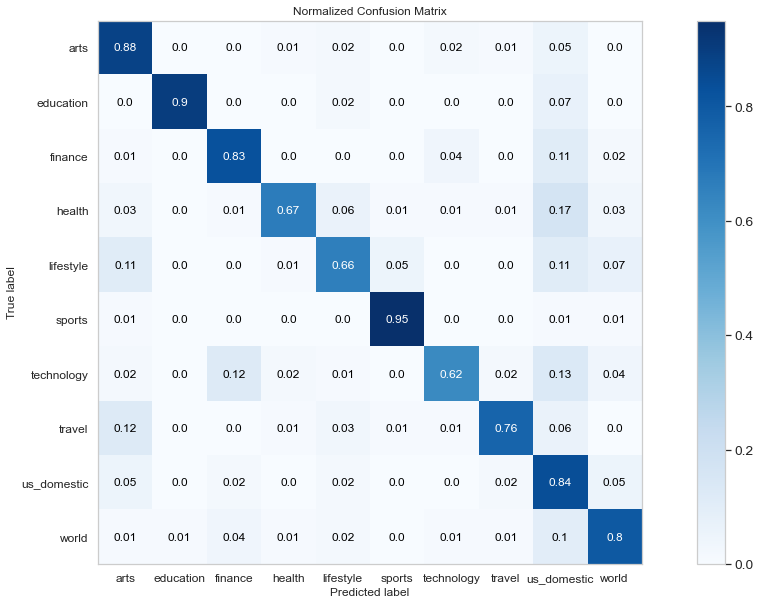

In [169]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_cv_nb, normalize=True, figsize=(20,10), text_fontsize='large')
plt.show()

Based on the above confusion matrix, the Naïve Bayes classifier has performed a good job with a high percentage of true labels predicted. 

#### (ii) Error metrics

In [192]:
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, y_pred_cv_nb, normalize=True))
print("Precision score:", sklearn.metrics.precision_score(y_test, y_pred_cv_nb, average='weighted'))
print("Recall score:", sklearn.metrics.recall_score(y_test, y_pred_cv_nb, average='weighted'))
print("f1 score:", sklearn.metrics.f1_score(y_test, y_pred_cv_nb, average='weighted'))

Accuracy score: 0.8193584693303321
Precision score: 0.8205580330899755
Recall score: 0.8193584693303321
f1 score: 0.817880220217597


Various error metrics such as the accuracy, precision, recall and f1-score were performed by comparing the test labels against the predicted labels. Overall, the scores obtained for the Naïve Bayes classifier was generally higher than the baseline of 0.5.

#### Step 16: Save the model

In [193]:
# save the model for reloading in the deployed application.
# save the counter vectorizer in order to retain the vocabulary information

import pickle
from datetime import datetime

time = datetime.now().strftime("%Y-%m-%d")
path1 = 'nb_classifier-{}.pkl'.format(time)

path2 = 'nb_countvectoriser-{}.pkl'.format(time)
with open(path1, 'wb') as f1:
    pickle.dump(nb, f1)
    
with open(path2, 'wb') as f2:
    pickle.dump(cv, f2)

### Deployment of trained model

 #### Step 17: Reload the model

In [194]:
path1 = "nb_classifier-2020-06-25.pkl"
with open(path1, 'rb') as f:
    model = pickle.load(f)

# To check the class label
model.classes_

array(['arts', 'education', 'finance', 'health', 'lifestyle', 'sports',
       'technology', 'travel', 'us_domestic', 'world'], dtype='<U11')

#### Step 18: Reload the vectorizer

In [195]:
path2 = "nb_countvectoriser-2020-06-25.pkl"
with open(path2, 'rb') as f:
    trained_cv = pickle.load(f)

#### Step 19: Preprocess the next text

In [196]:
def preprocess(text):
    alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
    text = alphanumeric(text)
    text = punc_lower(text)
    return text

#### Step 20. Numerically encode the input

In [197]:
def encode_text_to_vector(cv, text):
       new_cv = CountVectorizer(stop_words='english', vocabulary=cv.vocabulary_)
       text_vector = new_cv.fit_transform( [text ] )
       return text_vector

#### Step 21: Predict the label

The example below takes in a next text from the command promts and call the functions defined above.
The predicted label is given.

In [201]:
new_text = input("Enter the new text > ")
new_text2 = preprocess(new_text)
new_text_vector = encode_text_to_vector(trained_cv, new_text2)
predicted_label = (model.predict(new_text_vector))
predicted_prob = model.predict_proba(new_text_vector) # this contains the probability score

print ("\n The text is predicted as <" , predicted_label , ">")

Enter the new text >  From China to Germany, the World Learns to Live With the Coronavirus  As mass infections strike even in places that had seemed to tame the coronavirus, officials are turning to targeted and fast-but-flexible approaches to stop third or fourth waves. China is testing restaurant workers and delivery drivers block by block. South Korea tells people to carry two types of masks for differing risky social situations. Germany requires communities to crack down when the number of infections hits certain thresholds. Britain will target local outbreaks in a strategy that Prime Minister Boris Johnson calls “Whac-A-Mole.”  Around the world, governments that had appeared to tame the coronavirus are adjusting to the reality that the disease is here to stay. But in a shift away from damaging nationwide lockdowns, they are looking for targeted ways to find and stop outbreaks before they become third or fourth waves.  While the details differ, the strategies call for giving govern


 The text is predicted as < ['world'] >


In [202]:
# For illustration - to show the classes (labels) that the model can predict
model.classes_

array(['arts', 'education', 'finance', 'health', 'lifestyle', 'sports',
       'technology', 'travel', 'us_domestic', 'world'], dtype='<U11')

In [203]:
# For illustration - to show the probability score associated to the predicted label
predicted_prob 

array([[6.56253547e-059, 4.46617810e-103, 4.53786432e-049,
        3.31651271e-018, 1.62392854e-034, 4.27353342e-073,
        7.56832312e-039, 1.74904149e-074, 3.06917283e-019,
        1.00000000e+000]])


##### Sample news snippet extracted from https://www.nytimes.com/2020/06/24/world/europe/countries-reopening-coronavirus.html

From China to Germany, the World Learns to Live With the Coronavirus

As mass infections strike even in places that had seemed to tame the coronavirus, officials are turning to targeted and fast-but-flexible approaches to stop third or fourth waves. China is testing restaurant workers and delivery drivers block by block. South Korea tells people to carry two types of masks for differing risky social situations. Germany requires communities to crack down when the number of infections hits certain thresholds. Britain will target local outbreaks in a strategy that Prime Minister Boris Johnson calls “Whac-A-Mole.”

Around the world, governments that had appeared to tame the coronavirus are adjusting to the reality that the disease is here to stay. But in a shift away from damaging nationwide lockdowns, they are looking for targeted ways to find and stop outbreaks before they become third or fourth waves.

While the details differ, the strategies call for giving governments flexibility to tighten or ease as needed. They require some mix of intensive testing and monitoring, lightning-fast response times by the authorities, tight border management and constant reminders to their citizens of the dangers of frequent human contact.

The strategies often force central governments and local officials to share data and work closely together, overcoming incompatible computer systems, turf battles and other longstanding bureaucratic rivalries. Already, in Britain, some local officials say their efforts are not coordinated enough. 

The shifting strategies are an acknowledgment that even the most successful countries cannot declare victory until a vaccine is found. They also show the challenge presented by countries like the United States, Brazil and India, where the authorities never fully contained initial outbreaks and from where the coronavirus will continue to threaten to spread.

“It’s always going to be with us,” said Simon James Thornley, an epidemiologist from the University of Auckland in New Zealand. “I don’t think we can eliminate the virus long term. We are going to need to learn to live with the virus.”

Even in places where the coronavirus appeared to be under control, big outbreaks remain a major risk. In Tokyo, there have been 253 new infections in the past week, 83 from a nightlife district. In Gütersloh in western Germany, more than 1,500 workers from a meat processing plant tested positive, prompting the authorities to shut down two districts. South Korea, another poster child for fast responses, has announced dozens of new infections in recent days.

In Rome, which recently emerged from one of the strictest lockdowns in Europe, 122 people have been linked to a cluster case at a hospital, the San Raffaele Pisana Institute. Several days later, 18 people who lived in a building with shared bathrooms came down with the virus.


#### Question 1: Was the outcome of the topic modelling and classification satisfactory?  Please elaborate on your answers.

Your answer: 

Yes, the outcome of the topic modelling and classification was satisfactory based on the confusion matrix and various error metrices used to evaluate the model. I am comfortable with the large amount of data used for training, which was a total of 8,884 articles. In addition, the use of the Naïve Bayes classifier has yet again proven to be suitable for text classification. I have also tested the trained model with various news snippets extracted from the internet and the results were great and within my expections of what the topic labels should be.


#### Question 2: Describe at least 3 issues that you have encountered with the data source. What text pre-preocessing methods did you apply to address these assumes?

Your answer:
1. The identification of the full list of punctuation marks identified from the dataset. Several runs of inspection was done to fully form the final list of punctuation marks.

2. Initially, I had tried to create a word list by combining all of the tokenised words in the hope of identfying the top 10 common words. This has proven to be unsuccessfully for my laptop to process as the kernel within JupyterLab died multiple times while trying to run the particular 2 lines of code. After much consideration, I had decided not to proceed with this step. Instead, I had converted the words into a simple vector representation, ie. Bag of Words. 

3. Lastly, much time had been wasted in the Colab virtual environment, which enabled me to perform step 2 (ie. word list with all the tokenised words). Armed with the created word list, I then fitted and transformed this word list into the tf_vectorizer before looping the LDA model through the possible range of topic numbers. This process took me a few hours to complete in Colab. The end result when I tried to evaluate the topic and terms were, to my horror, incomprehensible and held no meaning at all. I was unable to come up with any solid topic labels at all. After much investigation and research, I realised my mistake of fitting and processing the wrong variable. The correct variable to use was: tf_vectorized_documents = tf_vectorizer.fit_transform(df['tokens_lemma_with_pos']). Thus, I re-coded with step 2 in mind and used the correct variable for the tf_vectorizer and managed to run the entire piece of code with JupyterLab. The looping of the LDA model through the possible range of topic numbers took approximately 31 minutes to complete.

#### Question 3: Describe some key takeaways you have learnt from  this assignment.

Your answer:


The key takeaways from this assignment are as follows:

1. I have learnt how to piece the knowledge acquired and select the applicable steps to complete this assignment.

2. I have also learnt how to go about fulfilling a workflow - from the beginning steps of selecting a dataset which I am interested to work on, to the end where a suitable classification model has been trained to predict the topic labels of news snippets randomly extracted from the internet.

3. Last but not least, I have learnt to know when to stop and re-think about the process when the time taken to run the code is not justifiable at all. Compared to a computer vision task where images are being processed thereby warranting more time, the time to process text in NLP should not be more than that of a computer vision task especially when the dataset consists of only a total of 8,884 articles. This has probed me to investigate further and thus saving further unnecessary time wasted.